# Question Answering

## Setup

In [69]:
# Base requirements
!pip install farm-haystack[colab,preprocessing,elasticsearch,metrics,inference]
!pip install transformers
!pip install -U sentence-transformers
!pip install datasets

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import get_dataset_config_names
from datasets import load_dataset

import torch
from transformers import AutoTokenizer
from transformers import pipeline
from transformers import AutoModelForQuestionAnswering

import os
from subprocess import Popen, PIPE, STDOUT

## The Dataset
[SubjQA](https://arxiv.org/abs/2004.14283) Contains subjective answers and questions.

In [2]:
domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [3]:
subjqa = load_dataset("subjqa", name="electronics")
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [4]:
# Closer look.
# The answer.
subjqa["train"]["answers"][1]

{'text': ['Bass is weak as expected',
  'Bass is weak as expected, even with EQ adjusted up'],
 'answer_start': [1302, 1302],
 'answer_subj_level': [1, 1],
 'ans_subj_score': [0.5083333253860474, 0.5083333253860474],
 'is_ans_subjective': [True, True]}

In [5]:
# The question.
print(subjqa["train"]["question"][1])

Is this music song have a goo bass?


In [6]:
# The context
subjqa["train"]["context"][1]

'To anyone who hasn\'t tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they\'re good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer\'s sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they\'re very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I didn\'t find it as comfortable as many have claimed. Earpads are *very* thin and made my ears sore after 30 minutes of listening, although this can be remedied to a point by adjusting the "comfort zone" feature (tightening the temple pads while loosening the ear pads). The cord seems to be an average thickness, but I wouldn\'t get too rough with these. The steel headband adjusts smoothl

In [7]:
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"{split} size: {df['id'].nunique()}")

train size: 1295
test size: 358
validation size: 255


In [8]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [9]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

... what types of questions are in the training set?

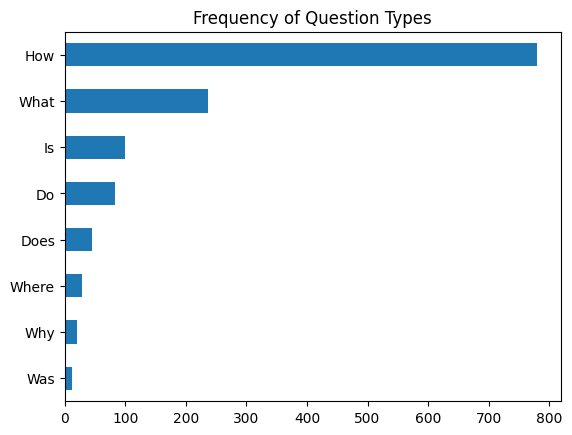

In [10]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]
for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [11]:
# Look at the Hows?
for question_type in ["How", "What", "Is"]:
  for question in (
      dfs["train"].query(
          "question.str.startswith(@question_type)"
        ).sample(n=3, random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Extracting Answers from Text
- Frame the supervised learning problem.
- Tokenize and encode text for QA tasks.
- Deal with long passages that exceed a model's maximum context size.

### Span classification
Span classification is a natural language processing task that involves identifying and labeling spans of text with semantic tags. A span is a contiguous sequence of tokens that represents a meaningful unit, such as a named entity, a phrase, or a sentence.

---
MiniLM - A distilled version of BERT-base that preserves 99% of the performance while being twice as fast.

### Tokenizing text for QA

In [12]:
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
# Test
question = "How much music can this hold?"
context =  """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

token_type_ids tensor indicates which part of the inputs corresponds to the ques‐
tion and context (a 0 indicates a question token, a 1 indicates a context token).

In [14]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [15]:
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [16]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [17]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


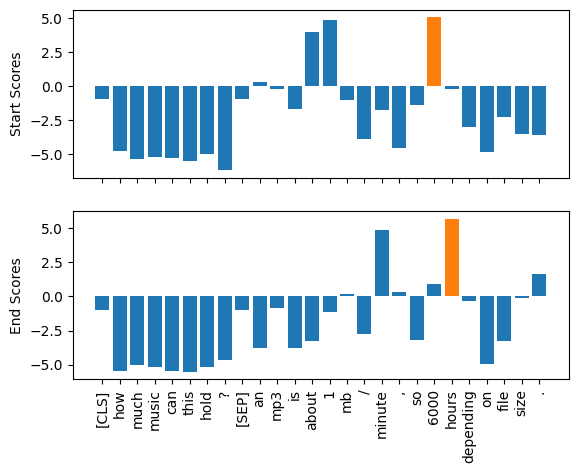

In [18]:
# Start & End Logits
s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [19]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


### transformers Pipeline

In [20]:
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:323: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651607394218445, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.2208300530910492,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253580659627914,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [21]:
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

### Dealing with long passages

In [22]:
example = dfs['train'].iloc[0][["question", "context"]]
tokenized_example = tokenizer(
    example["question"], example["context"], return_overflowing_tokens=True, max_length=100,
    stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [23]:
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [24]:
for window in tokenized_example["input_ids"]:
 print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



## Using Haystack to Build a QA Pipeline
### Intializing document store

In [25]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [28]:
# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
        stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [29]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "6b7aa40cf42e",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "RyojbpMzQ524jfMq8Q1IiA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [30]:
from haystack.document_stores import ElasticsearchDocumentStore

In [31]:
# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [32]:
for split, df in dfs.items():
  # Exclude duplicate reviews.
  docs = [{"content": row["context"],
           "meta": {
              "item_id": row["title"],
              "question_id": row["id"],
              "split": split}}
          for _, row in df.drop_duplicates(subset="context").iterrows()]
  document_store.write_documents(docs, index="document")

In [33]:
print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


### Initializing a retriever

In [34]:
from haystack.nodes import BM25Retriever
retriever = BM25Retriever(document_store=document_store)

In [35]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]}
)

In [36]:
retrieved_docs[0]

<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}>

### Initializing a reader

In [37]:
from haystack.nodes import FARMReader
model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(
    model_name_or_path=model_ckpt,
    progress_bar=False,
    max_seq_len=max_seq_length,
    doc_stride=doc_stride,
    return_no_answer=True
)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
reader.predict_on_texts(question=question, texts=[context], top_k=1)

{'query': 'How much music can this hold?',
 'no_ans_gap': 12.648086786270142,
 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293055176734924, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}

### Putting it all together

In [41]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, retriever)


In [53]:
n_answers = 3
preds = pipe.run(
    query=query,
    params={
        "Retriever": {"top_k": 3},
        "Reader": {"top_k": 3},
        "filters": {"item_id": [item_id], "split":["train"]}
    },
)

print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
 print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
 print(f"Review snippet: ...{preds['answers'][idx].context}...")
 print("\n\n")

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





## Improving Our QA Pipeline